# Image classification via fine-tuning with EfficientNet

**Author:** [Yixing Fu](https://github.com/yixingfu)<br>
**Date created:** 2020/06/30<br>
**Last modified:** 2020/07/16<br>
**Description:** Use EfficientNet with weights pre-trained on imagenet for Stanford Dogs classification.

# Experiment with Bilinear CNN
Bilinear CNN paper: http://vis-www.cs.umass.edu/bcnn/
With code from: https://github.com/NiFangBaAGe/FBCNN/blob/master/load_model.py

Self-connected Bilinear like Breast Cancer paper
https://www.frontiersin.org/articles/10.3389/fgene.2020.547327/full

Use Stanford Dogs. A subset of ImageNet-1k chosen for the task of fine-grained image categorization AKA texture AKA fluffiness.
https://www.tensorflow.org/datasets/catalog/stanford_dogs

Rotate the EfficientNet output vectors with PCA to create "meatier" feature vectors.

In [1]:
# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from sklearn.decomposition import IncrementalPCA as PCA
import matplotlib.pyplot as plt

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()


Not connected to a TPU runtime. Using CPU/GPU strategy
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [3]:
import tensorflow_datasets as tfds

batch_size = 64
pca_batch_size = 2048

dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes


When the dataset include images with various size, we need to resize them into a
shared size. The Stanford Dogs dataset includes only images at least 200x200
pixels in size. Here we resize the images to the input size needed for EfficientNet.

In [4]:
size = (IMG_SIZE, IMG_SIZE)
ds_pca = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

### Visualizing the data

The following code shows the first 9 images with their labels.

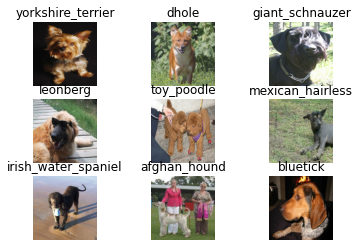

In [5]:
import matplotlib.pyplot as plt


def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]


label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")


### Data augmentation

We can use the preprocessing layers APIs for image augmentation.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

This `Sequential` model object can be used both as a part of
the model we later build, and as a function to preprocess
data before feeding into the model. Using them as function makes
it easy to visualize the augmented images. Here we plot 9 examples
of augmentation result of a given figure.

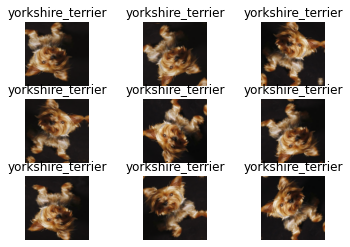

In [7]:
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")


### Prepare inputs

Once we verify the input data and augmentation are working correctly,
we prepare dataset for training. The input data are resized to uniform
`IMG_SIZE`. The labels are put into one-hot
(a.k.a. categorical) encoding. The dataset is batched.

Note: `prefetch` and `AUTOTUNE` may in some situation improve
performance, but depends on environment and the specific dataset used.
See this [guide](https://www.tensorflow.org/guide/data_performance)
for more information on data pipeline performance.

In [8]:
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)
ds_pca = ds_train
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)

ds_pca = ds_pca.batch(batch_size=pca_batch_size, drop_remainder=True)


A little code for plotting the results.

In [9]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


# plot_hist(hist)

# PCA Rotation Matrix
Create a PCA projection matrix from EfficientNetB0 vectors based on training dataset.

First, create a model that takes Stanford Dog training or test sets and projects them to the end of CNN pipeline, before the final classification top.

In [10]:
NUM_FEATURES=7*7*120

def build_model(num_classes, output_size=NUM_FEATURES):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    eff = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")
    # Freeze the pretrained weights
    eff.trainable = False
    sub_model = tf.keras.Model(inputs, eff.output, name='effb0')
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = sub_model(inputs)
    # x = layers.Reshape((7*7*NUM_FEATURES,1))(x)
    # print(x.shape)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model
bare_model = build_model(NUM_CLASSES)


In [11]:
pca = PCA()

batches = np.zeros((pca_batch_size, NUM_FEATURES), dtype='float32')
index = 0
sample = None
prev_x = None
deltas = []

for (images, labels) in ds_pca:
    # print(images.shape)
    pred = bare_model.predict(images)
    # print(pred.shape)
    flat = pred.reshape((pca_batch_size, NUM_FEATURES))
    if sample is None:
        sample = flat[0].reshape((NUM_FEATURES))
        print('sample:', sample)
    for i in range(flat.shape[0]):
        single = flat[i].reshape((NUM_FEATURES,))
        batches[index + i] = single
    index = index + flat.shape[0]
    if index == batches.shape[0]:
        pca.partial_fit(batches)
        x = pca.transform(sample.reshape((-1, NUM_FEATURES)))
        # print(x.shape, x[0,:6])
        if prev_x is not None:
            delta = np.mean(np.abs(prev_x - x))
            print('mean delta:', delta)
            deltas.append(delta)
        index = 0
        prev_x = x

print('matrix:', pca.components_.shape)

projected = pca.transform(batches)
print(projected.shape)
print(pca.components_)

sample: [0.00889863 0.00897301 0.00910063 ... 0.00643656 0.00441624 0.0077721 ]


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_incremental_pca.py:348: RuntimeWarning: Mean of empty slice.
  self.noise_variance_ = explained_variance[self.n_components_ :].mean()
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


mean delta: 0.015863964113442756
mean delta: 0.015758114520829123
mean delta: 0.015213950487381061
mean delta: 0.014371611943679655
matrix: (2048, 5880)
(2048, 2048)
[[-9.52701994e-04  4.28704958e-04 -1.28006627e-05 ... -8.26277770e-04
  -7.19115069e-04  2.41642142e-04]
 [-4.38293381e-04 -7.87386583e-04  1.10247579e-05 ...  2.35392354e-05
  -9.69390021e-05 -1.07356153e-03]
 [-1.63936354e-04  1.59375747e-04 -1.13031232e-03 ... -6.01135564e-04
  -3.55845383e-04 -4.47285334e-04]
 ...
 [-3.48997338e-03 -8.20179500e-03 -1.06154210e-02 ... -5.37252294e-03
   7.34653012e-03 -2.28057014e-03]
 [-5.18804595e-03  8.54399472e-05 -1.10809560e-04 ...  1.53507414e-03
  -1.21590953e-02 -1.11887747e-03]
 [-1.87283947e-03  6.29725265e-04  4.30475127e-03 ... -1.70576589e-02
  -1.65268578e-04 -3.41953260e-03]]


In [12]:
projected = pca.transform(batches)
print(projected.shape)
print(pca.components_)

(2048, 2048)
[[-9.52701994e-04  4.28704958e-04 -1.28006627e-05 ... -8.26277770e-04
  -7.19115069e-04  2.41642142e-04]
 [-4.38293381e-04 -7.87386583e-04  1.10247579e-05 ...  2.35392354e-05
  -9.69390021e-05 -1.07356153e-03]
 [-1.63936354e-04  1.59375747e-04 -1.13031232e-03 ... -6.01135564e-04
  -3.55845383e-04 -4.47285334e-04]
 ...
 [-3.48997338e-03 -8.20179500e-03 -1.06154210e-02 ... -5.37252294e-03
   7.34653012e-03 -2.28057014e-03]
 [-5.18804595e-03  8.54399472e-05 -1.10809560e-04 ...  1.53507414e-03
  -1.21590953e-02 -1.11887747e-03]
 [-1.87283947e-03  6.29725265e-04  4.30475127e-03 ... -1.70576589e-02
  -1.65268578e-04 -3.41953260e-03]]


In [13]:
print(pca.n_samples_seen_)

10240


Let's plot the mean delta across each sample during the training of IncrementalPCA. This shows that as the PCA is fine-tuned, the projection of the original sample jumps around less and less.

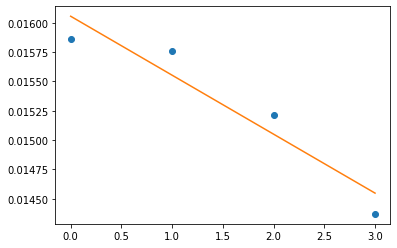

In [14]:
#deltas = [0.1, 0.2, 0.15, 0.3]
# datasets
x = np.array(range(len(deltas)), dtype='int32')
y = np.asarray(deltas)
#create basic scatterplot
plt.plot(x, y, 'o')

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)

#add linear regression line to scatterplot 
plt.plot(x, m*x+b)

Second, let's plot the classic display of what PCA is all about. PCA projects an N-dimensional space such that the members of the 0-th cell of the output vector has the highest standard deviation, the 1-th cell the second highest stdev, etc.

(2048, 2048)
(2048,)


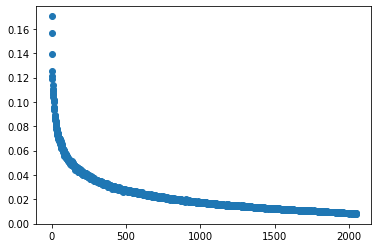

In [15]:
transp = np.transpose(projected)
print(transp.shape)
std = np.ndarray.std(transp, axis=-1)
print(std.shape)
x = np.array(range(std.shape[0]), dtype='int32')
y = np.asarray(std)
#create basic scatterplot
plt.plot(x, y, 'o')

What this means for our purposes is that we have "concentrated" the variation between embeddings into a smaller set of numbers.

# Bilinear CNN
This layer creates a matrix where the columns are the channel values for all feature maps, and the rows are height X width of the feature maps. It then creates the 'outer product' of the matrix multiplied against itself.

In [16]:
!pip install -q git+https://github.com/LanceNorskog/keras-fbcnn.git
from keras_fbcnn import BilinearCNN2D

## Transfer learning from pre-trained weights

Here we initialize the model with pre-trained ImageNet weights,
and we fine-tune it on our own dataset.

In [17]:

def build_model(num_classes, bilinear=False):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    eff = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")
    # Freeze the pretrained weights
    eff.trainable = False
    sub_model = tf.keras.Model(inputs, eff.output, name='effb0')
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    sub_layer = sub_model(inputs)

    # Build either bilinear or classic global-average-pooling top
    if bilinear:
        x = BilinearCNN2D()([sub_layer, sub_layer])
    else:
        x = layers.GlobalAveragePooling2D(name="avg_pool")(sub_layer)
        x = layers.BatchNormalization()(x)
        top_dropout_rate = 0.2
        x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return eff, model


For the sake of benchmarking, we will create a model, compile the tensor graph, and throw it away- just to warm up the tensor compiler.

In [18]:
import time
with strategy.scope():
    block_model, model = build_model(num_classes=NUM_CLASSES)
    prediction = model.predict(np.zeros((1,IMG_SIZE,IMG_SIZE,3)))
    t1 = time.perf_counter()
    prediction = model.predict(np.zeros((128, IMG_SIZE, IMG_SIZE, 3)))
    t2 = time.perf_counter()
    print('(original) time taken to run:',t2-t1)
    print('(original) time taken per image:', (t2-t1)/128)
    block_model, model = build_model(num_classes=NUM_CLASSES, bilinear=True)
    prediction = model.predict(np.zeros((1,IMG_SIZE,IMG_SIZE,3)))
    t1 = time.perf_counter()
    prediction = model.predict(np.zeros((128, IMG_SIZE, IMG_SIZE, 3)))
    t2 = time.perf_counter()
    print('(bilinear) time taken to run:',t2-t1)
    print('(bilinear) time taken per image:', (t2-t1)/128)



INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


(original) time taken to run: 3.8157663299998603
(original) time taken per image: 0.02981067445312391


(bilinear) time taken to run: 3.873206950000167
(bilinear) time taken per image: 0.030259429296876306


First, train a standard classification top.

In [19]:
with strategy.scope():
    block_model, model = build_model(num_classes=NUM_CLASSES)

epochs = 80  # @param {type: "slider", min:2, max:80}
model.summary()
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, 
                callbacks=[early_stopping], verbose=2)
plot_hist(hist)

Model: "EfficientNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 effb0 (Functional)          (None, 7, 7, 1280)        4049571   
                                                                 
 avg_pool (GlobalAveragePool  (None, 1280)             0         
 ing2D)                                                          
                                                                 
 batch_normalization_1 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 top_dropout (Dropout)       (None, 1280)              0         
                                                                 
 pred (Dense)                (None, 120)              

KeyboardInterrupt: ignored

In [ ]:
_, generic_accuracy_train =  model.evaluate(ds_train)
_, generic_accuracy_test =  model.evaluate(ds_test)

Next, train a Bilinear top.

In [ ]:
with strategy.scope():
    block_model, model = build_model(num_classes=NUM_CLASSES, bilinear=True)

epochs = 80  # @param {type: "slider", min:2, max:80}
model.summary()
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, 
                callbacks=[early_stopping], verbose=2)
plot_hist(hist)

In [ ]:
_, bilinear_accuracy_train =  model.evaluate(ds_train)
_, bilinear_accuracy_test =  model.evaluate(ds_test)

In [ ]:
print('Accuracy for Generic Top, Training/Testing\n\t', generic_accuracy_train, '\n\t', generic_accuracy_test)
print('Accuracy for Bilinear Top, Training/Testing\n\t', bilinear_accuracy_train, '\n\t', bilinear_accuracy_test)